In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
%matplotlib inline
plt.style.use('fivethirtyeight')

import warnings
warnings.simplefilter("ignore", DeprecationWarning)

In [40]:
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

from src.text_pipeline import text_to_vector, preprocess, remove_stopwords, stemmer
from sklearn.metrics.pairwise import cosine_similarity



In [3]:
all_transcripts = pd.read_csv('tables/all_transcripts')
emotions = pd.read_csv('NRC-Emotion-Lexicon/NRC-Emotion-Lexicon-v0.92/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt',
                       names=['word', 'emotion', 'association'], skiprows=45, sep='\t')


In [4]:
all_transcripts = all_transcripts[all_transcripts['Speaker'] != 'speaker']
all_transcripts = all_transcripts[all_transcripts['Speaker'] != 'bennet']
all_transcripts = all_transcripts[all_transcripts['Speaker'] != 'question']

In [5]:
bow_transcripts = all_transcripts.groupby('Speaker')['Line'].apply(' '.join)

In [6]:
bow_transcripts = bow_transcripts.to_frame()

In [7]:
speaker_dummies = pd.get_dummies(bow_transcripts.index)

In [8]:
vectorizer, vector, vector_pd = text_to_vector(bow_transcripts['Line'])

In [9]:
vector_pd

,000,00000702,00010101,00010336,000131,00013615,000219,000232,000243,000252,...,zach,zack,zealand,zelenski,zero,zest,zip,zippo,zone,zuckerberg
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,18,0,3,0,2,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,1,...,0,0,1,0,8,0,0,0,3,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
lda = LDA(n_components=5, n_jobs=1)
lda.fit(vector_pd)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=5, n_jobs=1,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)

In [11]:
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words -1:-1]]))

In [12]:
print_topics(lda, vectorizer, 10)


Topic #0:
american countri peopl becaus job know money need right way

Topic #1:
colorado stimul ferguson humanitarian co2 thrive 180 loser malpractic delaney

Topic #2:
peopl think make presid know right just becaus countri want

Topic #3:
countri texa everyon member law challeng el paso face ensur

Topic #4:
shotgun pistol orlando gifford census prosector eras exit diaper manner


#### Some of the most latent topics can be seen. In the top 5 topics, you can see a focus on certain issues such as gun control and jobs.

In [14]:
cosine_sim = cosine_similarity(vector_pd, vector_pd)

In [15]:
all_transcripts.Speaker.unique()

array(['warren', 'klobuchar', 'orourke', 'booker', 'castro', 'gabbard',
       'blasio', 'delaney', 'ryan', 'sanders', 'biden', 'harris',
       'hickenlooper', 'gillibrand', 'buttigieg', 'yang', 'swalwell',
       'bullock', 'williamson', 'inslee', 'steyer', 'bloomberg'],
      dtype=object)

In [16]:
indices = pd.Series(bow_transcripts.index)

def recommendations(candidate, cosine_sim = cosine_sim):
    
    # initializing the empty list of similar candidates
    similar_candidate = []
    
    # gettin the index of the candidate that matches the title
    idx = indices[indices == candidate].index[0]

    # creating a Series with the similarity scores in descending order
    score_series = pd.Series(cosine_sim[idx]).sort_values(ascending = False)

    # getting the indexes of the 3 most similar candidate
    top_3_indexes = list(score_series.iloc[1:4].index)
    
    # populating the list with the candidates
    for i in top_3_indexes:
        similar_candidate.append(list(bow_transcripts.index)[i])
        
    return similar_candidate

In [17]:
recommendations('booker', cosine_sim)

['buttigieg', 'harris', 'warren']

In [18]:
recommendations('sanders', cosine_sim)

['warren', 'buttigieg', 'klobuchar']

In [19]:
recommendations('biden', cosine_sim)

['klobuchar', 'buttigieg', 'warren']

In [20]:
recommendations('harris', cosine_sim)

['booker', 'warren', 'sanders']

In [21]:
recommendations('klobuchar', cosine_sim)

['buttigieg', 'warren', 'biden']

In [22]:
recommendations('yang', cosine_sim)

['booker', 'warren', 'buttigieg']

#### In general, the Candidates that have found success in the debates and in the primaries (as of February 27, 2020) are similar to each other in what they say. Candidates who have not performed as well share similarities with each other.

In [31]:
all_transcripts['processed'] = stemmer(remove_stopwords(all_transcripts['Line']))

In [32]:
all_transcripts

,Line,Speaker,State,processed
2,thank you. it’s good to be here.,warren,florida,thank you. it good here.
4,i think of it this way. who is this economy r...,warren,florida,think way. economi realli work for? it great t...
5,it’s doing great for giant oil companies that...,warren,florida,it great giant oil compani want drill everywhe...
7,"well, first the economy. we know that not eve...",klobuchar,florida,"well, first economy. know everyon share prospe..."
8,"secondly, i’d use pell grants. i’d double the...",klobuchar,florida,"secondly, i'd use pell grants. i'd doubl $6,00..."
...,...,...,...,...
10396,my campaign is bigger and stronger now because...,warren,nevada,campaign bigger stronger peopl work julian cam...
10397,someone was taking a picture the other day whe...,warren,nevada,someon take pictur day one campaign headquarte...
10398,"and julian castro, who has endorsed me, who is...",warren,nevada,"julian castro, endors me, line."
10399,"i swear to you, i could not ask for a better p...",warren,nevada,"swear you, could ask better partner julian. le..."


In [33]:
dummied_df = pd.concat([all_transcripts.drop(['Speaker'], axis=1), pd.get_dummies(all_transcripts['Speaker'])], axis=1)

In [35]:
vectorizer, vector, vector_pd = text_to_vector(dummied_df['processed'])

In [38]:
X_train, X_test, y_train, y_test = train_test_split(vector_pd, dummied_df['biden'])

In [41]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_pred_class = rf.predict(X_test)
rf_prob = rf.predict_proba(X_test)

print(f1_score(y_test, rf_pred_class, average='weighted'))
print(precision_score(y_test, rf_pred_class, average='weighted'))
print(recall_score(y_test, rf_pred_class, average='weighted'))

0.7892072296040332
0.8229264778207492
0.8382078406969509


In [42]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
lr_prob = lr.predict_proba(X_test)

print(f1_score(y_test, lr_pred, average='weighted'))
print(precision_score(y_test, lr_pred, average='weighted'))
print(recall_score(y_test, lr_pred, average='weighted'))

0.8612541607665409
0.8670502150317856
0.8761667703795893


In [43]:
nb = MultinomialNB()
nb.fit(X_train, y_train)
nb_pred = nb.predict(X_test)
nb_prob = nb.predict_proba(X_test)
print(f1_score(y_test, nb_pred, average='weighted'))
print(precision_score(y_test, nb_pred, average='weighted'))
print(recall_score(y_test, nb_pred, average='weighted'))

0.86178093233251
0.8637641285060224
0.8742999377722465


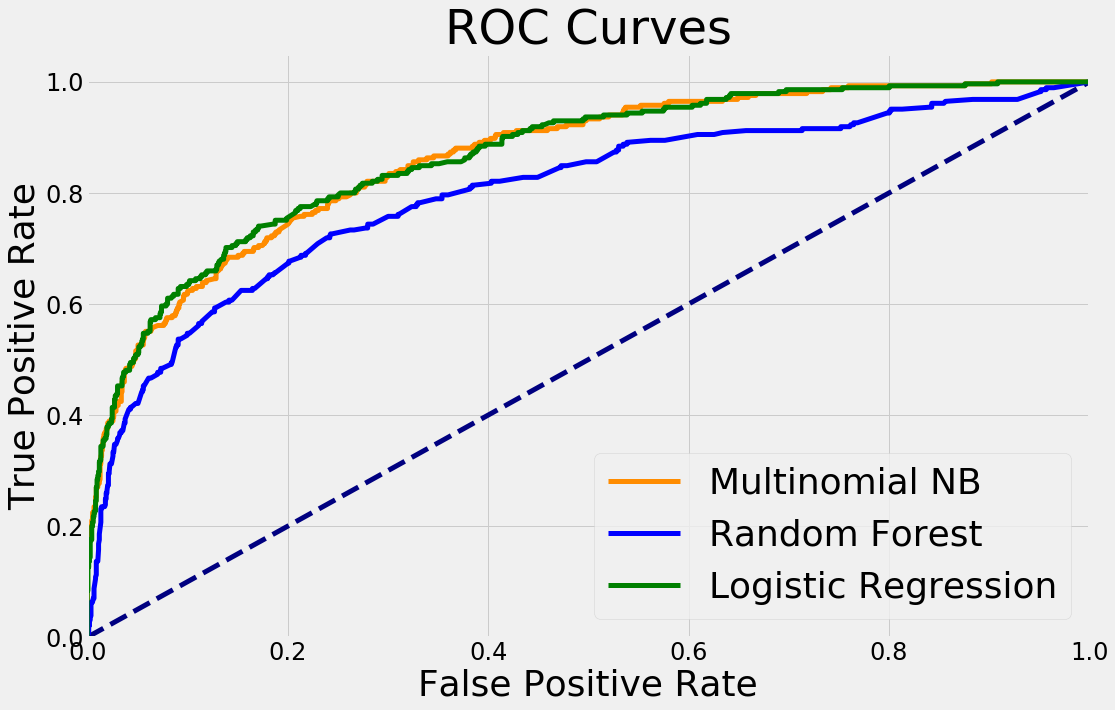

In [44]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test, nb_prob[:,1])
    
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), nb_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

rpr = dict()
dpr = dict()
doc_auc = dict()

for i in range(2):
    rpr[i], dpr[i], _ = roc_curve(y_test, rf_prob[:,1])
    
rpr["micro"], dpr["micro"], _ = roc_curve(y_test.ravel(), rf_pred_class.ravel())
doc_auc["micro"] = auc(rpr["micro"], dpr["micro"])

lpr = dict()
mpr = dict()
doc_auc = dict()

for i in range(2):
    lpr[i], mpr[i], _ = roc_curve(y_test, lr_prob[:,1])
    
lpr["micro"], mpr["micro"], _ = roc_curve(y_test.ravel(), lr_pred.ravel())
doc_auc["micro"] = auc(lpr["micro"], mpr["micro"])

plt.figure(figsize = (16,10))
lw = 5
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='Multinomial NB')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.plot(rpr[1], dpr[1], color = 'blue',
        lw=lw, label = 'Random Forest')
plt.plot(lpr[1], mpr[1], color = 'green',
        lw=lw, label = 'Logistic Regression')
plt.xlim([0.0, 1.0])
plt.xticks(fontsize = 24)
plt.yticks(fontsize = 24)
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize = 36)
plt.ylabel('True Positive Rate', fontsize = 36)
plt.title('ROC Curves', fontsize = 48)
plt.legend(loc="lower right", fontsize= 36)
plt.show()